# NicheSphere data preprocessing tutorial

NicheSphere is an sc-verse compatible Python library which allows the user to find differentially co-localized cellular niches and biological processes involved in their interactions based on cell type pairs co-localization probabilities in different conditions. Cell type pair co-localization probabilities are obtained in different ways: from deconvoluted Visium 10x / PIC-seq data (probabilities of finding each cell type in each spot / multiplet), or counting cell boundaries overlaps for each cell type pair in single cell spatial data (MERFISH , CODEX ...). This is addressed in the differential co-localization tutorial.

NicheSphere also offers the possibility to look at localized differential cell - cell communication based on Ligand-Receptor pairs expression data. This is addressed in the localized differential communication tutorial.

This tutorial focuses on the data **pre-processing** needed before doing the differential co-localization and localized process based differential communication analyses. 

## 1. Libraries and functions

In [1]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import networkx as nx
import warnings
import scanpy as sc
import mudata as md
import numpy as np
from community_layout.layout_class import CommunityLayout
warnings.filterwarnings("ignore")

import nichesphere

COMMUNITY LAYOUT: Datashader not found, edge bundling not available


## 2. Data at first glance

In this example we will use data from the Myocardial Infarction atlas from Kuppe, C. et. Al., 2022

In [2]:
mudata=md.read('heart_MI_ST_SC_23samples.h5mu')
mudata

MuData object with n_obs × n_vars = 206792 × 39120
  2 modalities
    visium:	73904 x 11704
      obs:	'n_counts', 'n_genes', 'percent.mt', 'Adipocyte', 'Cardiomyocyte', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'Cycling.cells', 'vSMCs', 'cell_type_original', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'patient_region_id', 'orig_ident', 'batch'
      var:	'features'
      obsm:	'X_pca', 'X_spatial', 'X_umap'
    sc:	132888 x 27416
      obs:	'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'doublet_score', 'doublet', 'dissociation_s1', 'opt_clust', 'patient', 'batch', 'opt_clust_integrated', 'cell_type', 'ident', 'nFeaturess_RNA', 'cell_subtype', 'cell_subtype_available', 'cell_subtype2', 'patient_region_id', 'patient_group', 'sampleType'
      var:	'n_counts'
      obsm:	'X_harmony', 'X_pca', 'X_umap_harmony'

This is a subset with 23 samples (samples with less than 1500 cells in the snRNA-seq data were filtered out), and 33 different cell subtypes

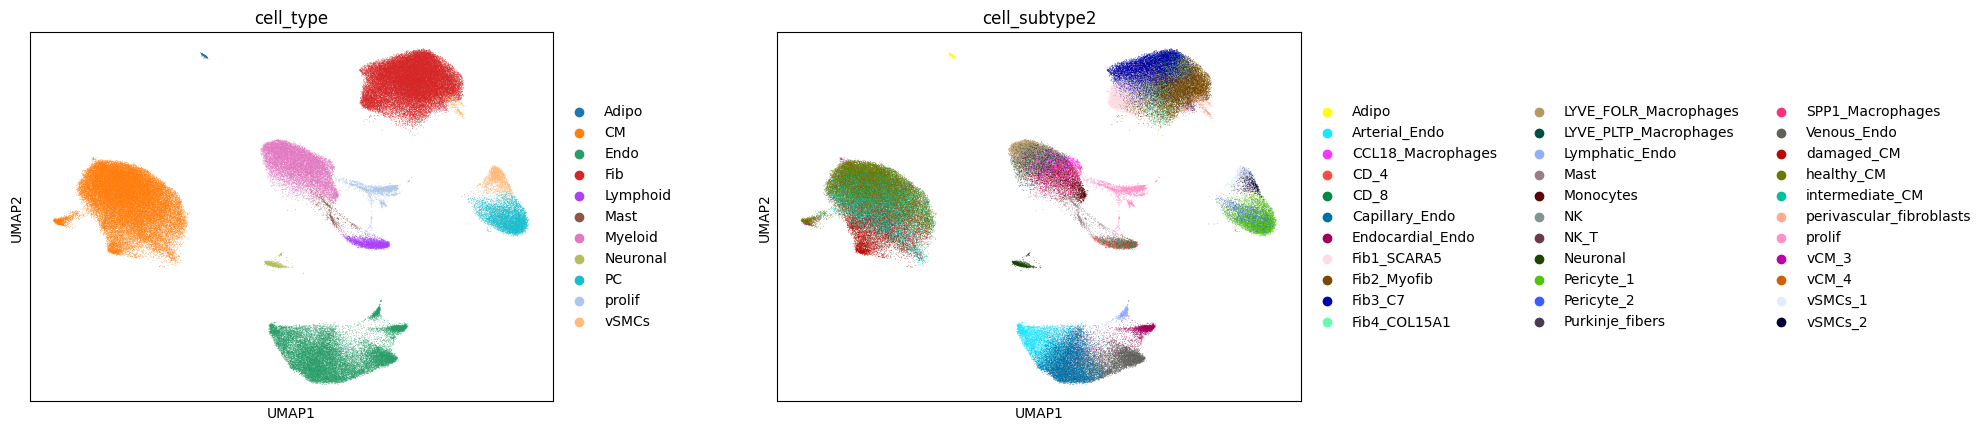

In [3]:
mudata['sc'].obsm['umap']=mudata['sc'].obsm['X_umap_harmony']
sc.pl.umap(mudata['sc'], 
           color=['cell_type', 'cell_subtype2'], wspace=0.3)

## 3. For differential co-localization

In this case, we will get cell type co-localization probabilities from **deconvoluted Visium** data (Cell type probabilities per spot): 

In a previous step, we used MOSCOT(Klein et. al., 2025) to deconvolute cell subtypes in visium slices from the same 23 samples , getting matrices of probabilities of each cell being in each spot. Now we will get cell type probabilities per spot summing the probabilities of cells of the same kind in each spot; thus getting cell type probability matrices for all spots per sample. This can be done with the **get_spot_ct_props** function from NicheSphere. As an example, we will do this for two samples: control sample **control_P1** and ischemic sample **GT_IZ_P9**

In [4]:
CTprops=pd.DataFrame()
for smpl in ['control_P1', 'GT_IZ_P9']:
    t=pd.read_csv('cell_probs_'+smpl+'.csv', index_col=0)
    
    adata_sc=mudata['sc'][mudata['sc'].obs.patient_region_id==smpl]
    adata_sc=adata_sc[[ c in adata_sc.obs.cell_subtype2.value_counts().index[adata_sc.obs.cell_subtype2.value_counts()>2] for c in adata_sc.obs.cell_subtype2]]

    props=nichesphere.tl.get_spot_ct_props(spot_cell_props=t , sc_ct=adata_sc.obs.cell_subtype2)
    CTprops=pd.concat([CTprops, props])

In [5]:
CTprops.head()

,Fib1_SCARA5,damaged_CM,Capillary_Endo,LYVE_FOLR_Macrophages,Fib3_C7,healthy_CM,Fib2_Myofib,Endocardial_Endo,Arterial_Endo,Neuronal,...,vSMCs_1,CCL18_Macrophages,perivascular_fibroblasts,CD_4,vSMCs_2,Lymphatic_Endo,NK,CD_8,Purkinje_fibers,Adipo
AAACAAGTATCTCCCA-1-1-0-0-0,0.000000e+00,0.000000e+00,0.0,8.333133e-16,0.000000,0.000000e+00,0.428865,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN
AAACAATCTACTAGCA-1-1-0-0-0,0.000000e+00,2.691729e-21,0.0,0.000000e+00,0.445912,5.540884e-01,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN
AAACACCAATAACTGC-1-1-0-0-0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000030,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.499508,0.0,0.0,NaN
AAACAGAGCGACTCCT-1-1-0-0-0,1.373226e-25,0.000000e+00,0.0,0.000000e+00,0.499762,3.111796e-13,0.500238,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN
AAACAGCTTTCAGAAG-1-1-0-0-0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.443230,0.113118,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN


You can download the following table of cell type proportions in all samples from zenodo

In [6]:
CTprops=pd.read_csv('CTprops.csv', index_col=0)
CTprops.head()

,Fib1_SCARA5,damaged_CM,Capillary_Endo,LYVE_FOLR_Macrophages,Fib3_C7,healthy_CM,Fib2_Myofib,Endocardial_Endo,Arterial_Endo,Neuronal,...,CCL18_Macrophages,perivascular_fibroblasts,CD_4,vSMCs_2,Lymphatic_Endo,NK,CD_8,Purkinje_fibers,Adipo,NK_T
AAACAAGTATCTCCCA-1-1-0-0-0,0.000000e+00,0.000000e+00,0.0,8.333133e-16,0.000000,0.000000e+00,0.428865,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
AAACAATCTACTAGCA-1-1-0-0-0,0.000000e+00,2.691729e-21,0.0,0.000000e+00,0.445912,5.540884e-01,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
AAACACCAATAACTGC-1-1-0-0-0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000030,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.499508,0.0,0.0,NaN,NaN
AAACAGAGCGACTCCT-1-1-0-0-0,1.373226e-25,0.000000e+00,0.0,0.000000e+00,0.499762,3.111796e-13,0.500238,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
AAACAGCTTTCAGAAG-1-1-0-0-0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.443230,0.113118,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,NaN


From these deconvolution results, we can look at **cell type proportions per sample**. For this we will need the spot ID and sample correspondence:

In [7]:
spotSamples=mudata['visium'].obs.patient_region_id
spotSamples.reset_index().head()

,index,patient_region_id
0,AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,control_P17
1,AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,control_P17
2,AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,control_P17
3,AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,control_P17
4,AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,control_P17


A way to check the deconvolution proportions is using a clustermap

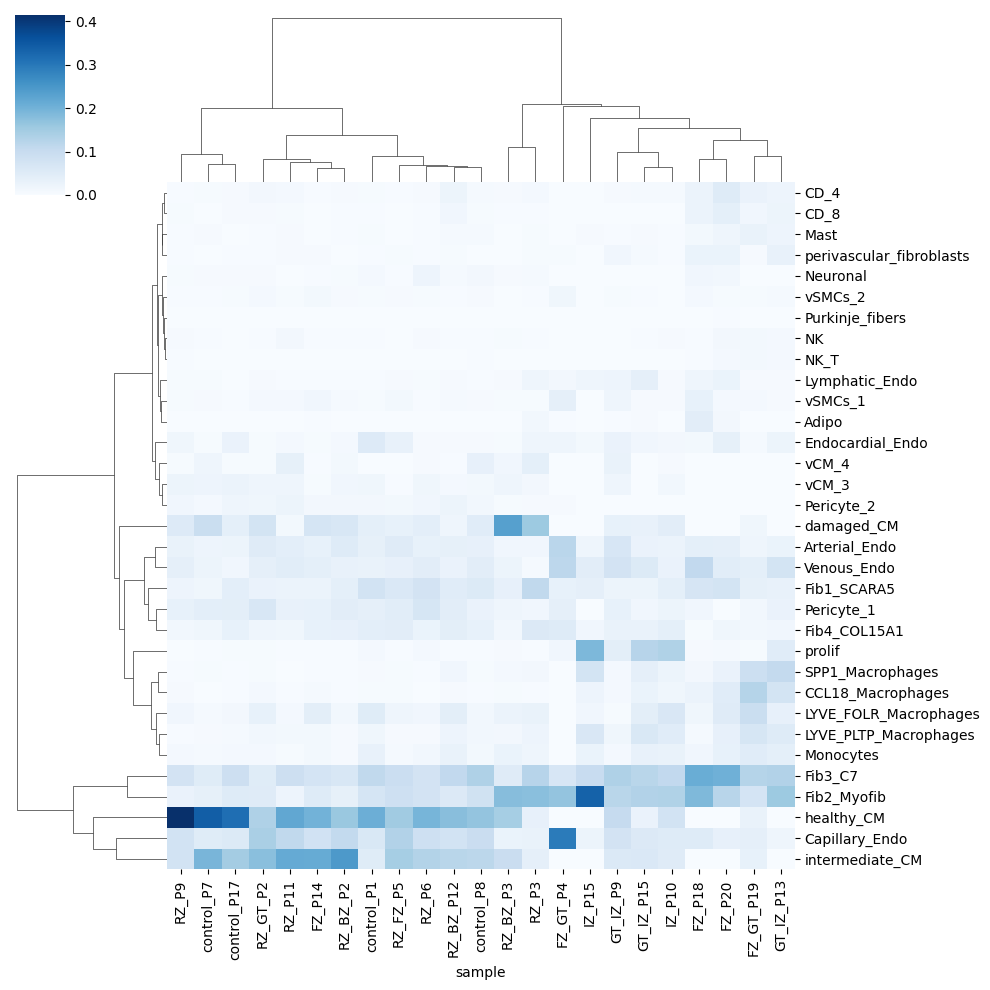

In [8]:
CTprops_sample=CTprops.copy()
CTprops_sample['sample']=mudata['visium'].obs.patient_region_id
sns.clustermap(CTprops_sample.groupby('sample').sum().T/CTprops_sample.groupby('sample').sum().sum(axis=1) , 
               cmap='Blues', method='ward')

Alternativelly, we can check the deconvolution proportions using barplots

In [9]:
t1=pd.DataFrame(CTprops[spotSamples=='control_P7'].sum(), columns=['control_P7'])
t2=pd.DataFrame(CTprops[spotSamples=='IZ_P15'].sum(), columns=['IZ_P15'])

Text(0.5, 1.0, 'IZ_P15')

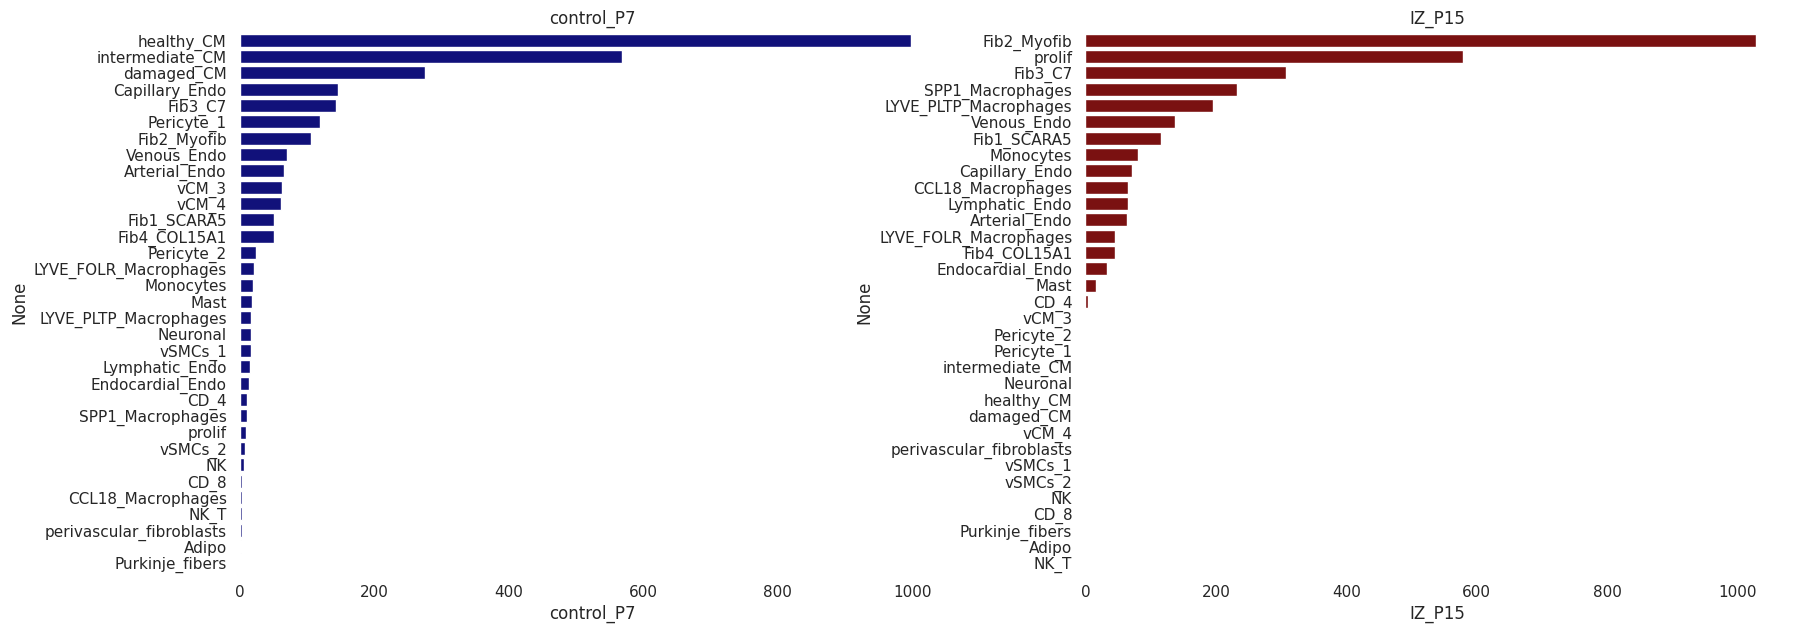

In [10]:
sns.set(font_scale=1)
sns.set_style(rc = {'axes.facecolor': 'white'})

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

sns.barplot(ax=axes[0], y=t1.sort_values('control_P7', ascending=False).index, x='control_P7', 
            data=t1.sort_values('control_P7', ascending=False), color='darkblue')
axes[0].set_title('control_P7')

sns.barplot(ax=axes[1], y=t2.sort_values('IZ_P15', ascending=False).index, x='IZ_P15',
            data=t2.sort_values('IZ_P15', ascending=False), color='darkred')
axes[1].set_title('IZ_P15')

We can visualize **cell type deconvolution results in slices** (spots are colored by the the cell type with highest proportion). For this we will need the spatial coordinates of the spots in the Visium slices need to be in the slot **uns['spatial']** of the Visium anndata object:

In [11]:
mudata['visium'].uns['spatial']=mudata['visium'].obsm['X_spatial']

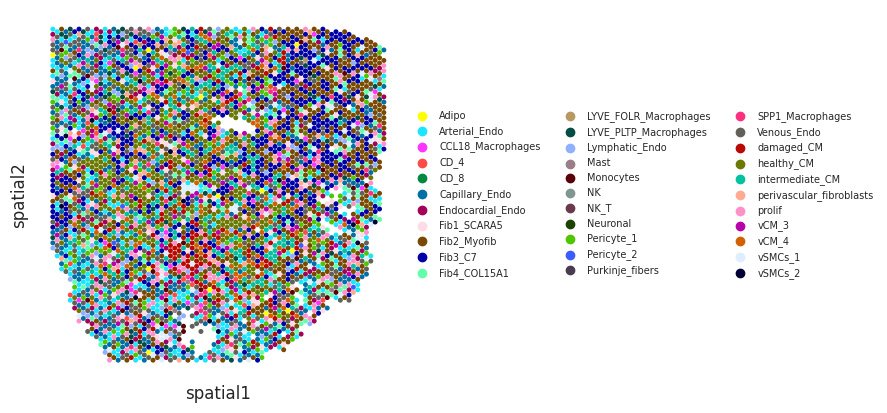

In [12]:
idPat = 'GT_IZ_P9'
nichesphere.coloc.spatialCTPlot(adata=mudata['visium'][mudata['visium'].obs.patient_region_id==idPat].copy(), 
                                CTprobs=CTprops.loc[spotSamples.index[spotSamples==idPat]], 
                                cell_types=mudata['sc'].obs.cell_subtype2, spot_size=0.015, 
                                legend_fontsize=7)

## 3.1 During differential co-localization analysis

We will compute then co-localization probabilities from the cell type probability matrices. Here will get concatenated co-localization sample matrices of cell type x cell type.

In [13]:
CTcolocalizationP=nichesphere.coloc.getColocProbs(CTprobs=CTprops, 
                                                  spotSamples=mudata['visium'].obs.patient_region_id #Series of spot samples with spot ID as index
                                                 )

Then we reshape the co-localization data into a matrix of cell type pairs x samples. We set the parameter **complete** = 1 because we have a simetrical matrix including both co-localization probabilities of cell type pair a - b , as well as b - a (which have the same probability)

In [14]:
colocPerSample=nichesphere.coloc.reshapeColoc(CTcoloc=CTcolocalizationP, 
                                              complete=1)
colocPerSample.head()

,Fib1_SCARA5-Fib1_SCARA5,Fib1_SCARA5-damaged_CM,Fib1_SCARA5-Capillary_Endo,Fib1_SCARA5-LYVE_FOLR_Macrophages,Fib1_SCARA5-Fib3_C7,Fib1_SCARA5-healthy_CM,Fib1_SCARA5-Fib2_Myofib,Fib1_SCARA5-Endocardial_Endo,Fib1_SCARA5-Arterial_Endo,Fib1_SCARA5-Neuronal,...,NK_T-CCL18_Macrophages,NK_T-perivascular_fibroblasts,NK_T-CD_4,NK_T-vSMCs_2,NK_T-Lymphatic_Endo,NK_T-NK,NK_T-CD_8,NK_T-Purkinje_fibers,NK_T-Adipo,NK_T-NK_T
control_P17,0.017603,0.000308,0.000992,0.000251,0.007062,0.002586,0.004724,0.000943,0.000412,0.000351,...,2.290066e-15,0.0,3.915381e-05,0.0,0.0,4.538656e-08,4.556003e-08,0.0,0.000000e+00,0.000268
RZ_P9,0.009307,0.000429,0.000738,0.000003,0.005204,0.001439,0.001625,0.000065,0.000168,0.000046,...,0.000000e+00,0.0,4.640548e-05,0.0,0.0,9.954633e-05,1.643486e-05,0.0,0.000000e+00,0.000784
IZ_P15,0.030351,0.000000,0.000027,0.000186,0.001200,0.000000,0.003112,0.000072,0.000062,0.000000,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000
RZ_P6,0.040470,0.000441,0.002752,0.000361,0.008687,0.002928,0.007878,0.000176,0.001022,0.001170,...,0.000000e+00,0.0,7.998369e-25,0.0,0.0,8.593925e-28,0.000000e+00,0.0,0.000000e+00,0.000438
RZ_BZ_P3,0.021508,0.000292,0.000567,0.000057,0.002408,0.000483,0.006635,0.000123,0.000052,0.000052,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,8.585311e-06,0.000000e+00,0.0,7.294563e-35,0.000897


The sum of the probabilities of every cell type pair in a sample must be = 1

In [15]:
colocPerSample.sum(axis=1)

control_P17    1.0
RZ_P9          1.0
IZ_P15         1.0
RZ_P6          1.0
RZ_BZ_P3       1.0
FZ_P14         1.0
RZ_BZ_P12      1.0
FZ_GT_P4       1.0
GT_IZ_P13      1.0
GT_IZ_P15      1.0
FZ_P20         1.0
RZ_FZ_P5       1.0
GT_IZ_P9       1.0
RZ_P3          1.0
FZ_GT_P19      1.0
FZ_P18         1.0
IZ_P10         1.0
control_P7     1.0
RZ_P11         1.0
control_P1     1.0
RZ_BZ_P2       1.0
control_P8     1.0
RZ_GT_P2       1.0
dtype: float64

This is how we got the file from zenodo **colocPerSample.csv**

In [16]:
colocPerSample=pd.read_csv('colocPerSample.csv', index_col=0)
colocPerSample.head()

,Fib1_SCARA5-Fib1_SCARA5,Fib1_SCARA5-damaged_CM,Fib1_SCARA5-Capillary_Endo,Fib1_SCARA5-LYVE_FOLR_Macrophages,Fib1_SCARA5-Fib3_C7,Fib1_SCARA5-healthy_CM,Fib1_SCARA5-Fib2_Myofib,Fib1_SCARA5-Endocardial_Endo,Fib1_SCARA5-Arterial_Endo,Fib1_SCARA5-Neuronal,...,NK_T-CCL18_Macrophages,NK_T-perivascular_fibroblasts,NK_T-CD_4,NK_T-vSMCs_2,NK_T-Lymphatic_Endo,NK_T-NK,NK_T-CD_8,NK_T-Purkinje_fibers,NK_T-Adipo,NK_T-NK_T
control_P17,0.017603,0.000308,0.000992,0.000251,0.007062,0.002586,0.004724,0.000943,0.000412,0.000351,...,2.290066e-15,0.0,3.915381e-05,0.0,0.0,4.538656e-08,4.556003e-08,0.0,0.000000e+00,0.000268
RZ_P9,0.009307,0.000429,0.000738,0.000003,0.005204,0.001439,0.001625,0.000065,0.000168,0.000046,...,0.000000e+00,0.0,4.640548e-05,0.0,0.0,9.954633e-05,1.643486e-05,0.0,0.000000e+00,0.000784
IZ_P15,0.030351,0.000000,0.000027,0.000186,0.001200,0.000000,0.003112,0.000072,0.000062,0.000000,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000
RZ_P6,0.040470,0.000441,0.002752,0.000361,0.008687,0.002928,0.007878,0.000176,0.001022,0.001170,...,0.000000e+00,0.0,7.998369e-25,0.0,0.0,8.593925e-28,0.000000e+00,0.0,0.000000e+00,0.000438
RZ_BZ_P3,0.021508,0.000292,0.000567,0.000057,0.002408,0.000483,0.006635,0.000123,0.000052,0.000052,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,8.585311e-06,0.000000e+00,0.0,7.294563e-35,0.000897


The sum of the probabilities of every cell type pair in a sample must be = 1

In [17]:
colocPerSample.sum(axis=1)

control_P17    1.0
RZ_P9          1.0
IZ_P15         1.0
RZ_P6          1.0
RZ_BZ_P3       1.0
FZ_P14         1.0
RZ_BZ_P12      1.0
FZ_GT_P4       1.0
GT_IZ_P13      1.0
GT_IZ_P15      1.0
FZ_P20         1.0
RZ_FZ_P5       1.0
GT_IZ_P9       1.0
RZ_P3          1.0
FZ_GT_P19      1.0
FZ_P18         1.0
IZ_P10         1.0
control_P7     1.0
RZ_P11         1.0
control_P1     1.0
RZ_BZ_P2       1.0
control_P8     1.0
RZ_GT_P2       1.0
dtype: float64

**Conditions**

In this case, condition can be inferred from abbreviations in the sample names:

RZ = Remote zone
BZ = Border Zone
FZ = Fibrotic Zone
IZ = Ischemic Zone

In [18]:
sampleTypesDF=pd.DataFrame(colocPerSample.index, columns=['sample'])
sampleTypesDF['sampleType']='myogenic'

#tmp.obs.sampleType[tmp.obs['sample'].str.contains("BZ")]='border'
sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("RZ")]='remote'
sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("BZ")]='border'


sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("FZ")]='fibrotic'
sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("IZ")]='ischemic'
sampleTypesDF

,sample,sampleType
0,control_P17,myogenic
1,RZ_P9,remote
2,IZ_P15,ischemic
3,RZ_P6,remote
4,RZ_BZ_P3,border
5,FZ_P14,fibrotic
6,RZ_BZ_P12,border
7,FZ_GT_P4,fibrotic
8,GT_IZ_P13,ischemic
9,GT_IZ_P15,ischemic


This is how we got the file in zenodo **MI_sampleTypesDF.csv**

## 4. For differential communication

NicheSphere is suited to work with CrossTalkeR output tables which contain columns called **cellpair**, indicating the cell types involved in an interaction separated by '@'; and **allpair**, indicating cell types, ligand and receptor involved. Additionally, input tables for NicheSphere should contain columns indicating the **ligand** (gene_A), **receptor** (gene_B) and **communication score** (MeanLR). The names for these last 3 columns can be indicated in NicheSphere functions.

The following tables come from a CrossTalkeR run comparing **myogenic** and **ischemic** samples. They are the condition specific tables in the **LR_data_final** object:

In [19]:
crossTalker_ctrlComm=pd.read_csv('./crossTalker_tbl_myo_heart_exp_scSeqComm.csv', index_col=0)
crossTalker_iscComm=pd.read_csv('./crossTalker_tbl_isc_heart_exp_scSeqComm.csv', index_col=0)

CrossTalkeR tables contain strings indicating wether a gene is a ligand (|L), receptor (|R) or transcription factor (|TF). These strings will be removed as they might cause conflicts with code. 

In [20]:
crossTalker_ctrlComm=nichesphere.tl.processCTKRoutput(crossTalker_ctrlComm)
crossTalker_iscComm=nichesphere.tl.processCTKRoutput(crossTalker_iscComm)

## 4.1 Database

We are interested in cell communication related to fibrosis, so we will use a database which classifies ligands according to extracellular matrix (ECM) or immune cell recruitment related processes to look for disease related processes : 

In [21]:
allDBs=pd.read_csv('nichesphereDB_pmid.csv', index_col=0)
allDBs.head()

,Ligand,category,db,PMID
2,col1a1,Collagens,matrisome,36399478
3,col1a2,Collagens,matrisome,36399478
4,col1a1,Collagens,matrisome,36399478
5,col6a3,Collagens,matrisome,36399478
6,col1a2,Collagens,matrisome,36399478


<Axes: xlabel='count', ylabel='category'>

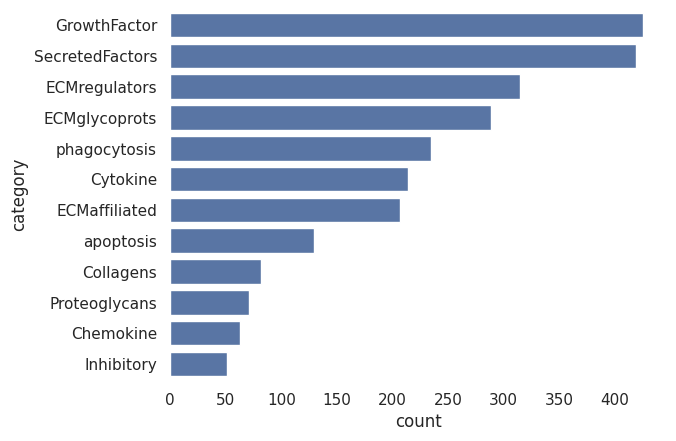

In [22]:
sns.barplot(x=allDBs.category.value_counts(), y=allDBs.category.value_counts().index,
            data=pd.DataFrame(allDBs.category.value_counts()))

## 4.2 During differential communication analysis

Now we can separate communication scores by process to know which cell type pairs and niche pairs are interacting through which processes in each condition.

Same cell type interactions will be excluded, so we'll have a list of same cell type interaction pairs in order to subset the data.

In [23]:
cell_types=CTprops.columns
oneCTints=cell_types+'-'+cell_types

For the calculation of the LR scores per process we will need the **cell pair - niche pair** correspondence table generated in the co-localization tutorial as **pairCatDFdir**

In [24]:
pairCatDFdir=pd.read_csv('./pairCatDFdir_MIvisium_louvain.csv')

In [25]:
myoCTpairScores_byCat2_dir_colocClusts=nichesphere.comm.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_ctrlComm, 
                                                                                   db=allDBs, dbCatCol='category', 
                                                                                   dbMatchCol='Ligand',        #column in database table to match with (ligand) column in the communication data table
                                                                                   ccommMatchCol='gene_A',     #column in communication data table to match with (ligand) column in the database table
                                                                                   ccommLRscoresCol='MeanLR', 
                                                                                   oneCTinteractions=oneCTints.str.replace('-', '@'), 
                                                                                   condition='myogenic', 
                                                                                   pairCatDF=pairCatDFdir)

In [27]:
iscCTpairScores_byCat2_dir_colocClusts=nichesphere.comm.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_iscComm, 
                                                                                   db=allDBs, 
                                                                                   dbCatCol='category', 
                                                                                   dbMatchCol='Ligand', 
                                                                                   ccommMatchCol='gene_A', 
                                                                                   ccommLRscoresCol='MeanLR', 
                                                                                   oneCTinteractions=oneCTints.str.replace('-', '@'), 
                                                                                   condition='ischemic', 
                                                                                   pairCatDF=pairCatDFdir)

In [28]:
myoCTpairScores_byCat2_dir_colocClusts.head()

,Unnamed: 0,cell_pairs,niche_pairs,LRscores,LRcat,condition
allpair,,,,,,
Adipo/COL14A1@Arterial_Endo/CD44,1031,Adipo->Arterial_Endo,1_Stromal->3_Healthy_CM,0.717175,Collagens,myogenic
Adipo/COL14A1@CCL18_Macrophages/CD44,1046,Adipo->CCL18_Macrophages,1_Stromal->4_Fibrotic,0.967985,Collagens,myogenic
Adipo/COL14A1@CD_4/CD44,1048,Adipo->CD_4,1_Stromal->2_Stressed_CM,0.967985,Collagens,myogenic
Adipo/COL14A1@CD_8/CD44,1052,Adipo->CD_8,1_Stromal->2_Stressed_CM,0.967985,Collagens,myogenic
Adipo/COL14A1@Fib1_SCARA5/CD44,1023,Adipo->Fib1_SCARA5,1_Stromal->1_Stromal,0.967985,Collagens,myogenic


Some interactions might be present only in one condition, so we will assign 0 values to the interactions that do not appear in one condition to be able to compare conditions

In [31]:
myoCTpairScores_byCat2_dir_colocClusts, iscCTpairScores_byCat2_dir_colocClusts = nichesphere.comm.equalizeScoresTables(ctrlTbl=myoCTpairScores_byCat2_dir_colocClusts, 
                                                                                                                       expTbl=iscCTpairScores_byCat2_dir_colocClusts, 
                                                                                                                       ctrlCondition='myogenic', 
                                                                                                                       expCondition='ischemic')

In [32]:
myoCTpairScores_byCat2_dir_colocClusts.head()

,Unnamed: 0,cell_pairs,niche_pairs,LRscores,LRcat,condition
allpair,,,,,,
Adipo/COL14A1@Arterial_Endo/CD44,1031,Adipo->Arterial_Endo,1_Stromal->3_Healthy_CM,0.717175,Collagens,myogenic
Adipo/COL14A1@CCL18_Macrophages/CD44,1046,Adipo->CCL18_Macrophages,1_Stromal->4_Fibrotic,0.967985,Collagens,myogenic
Adipo/COL14A1@CD_4/CD44,1048,Adipo->CD_4,1_Stromal->2_Stressed_CM,0.967985,Collagens,myogenic
Adipo/COL14A1@CD_8/CD44,1052,Adipo->CD_8,1_Stromal->2_Stressed_CM,0.967985,Collagens,myogenic
Adipo/COL14A1@Fib1_SCARA5/CD44,1023,Adipo->Fib1_SCARA5,1_Stromal->1_Stromal,0.967985,Collagens,myogenic


And this is how we get the tables **processed_myo_ctkr_louvainColoc.csv** and **processed_isc_ctkr_louvainColoc.csv** from zenodo